# 프로젝트 : Segmentation map으로 도로 이미지 만들기

|평가문항|상세기준|
|:---|:---|
|1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.|	데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.|
|2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.| U-Net generator, discriminator 모델 구현이 완료되어 train_step의 output을 확인하고 개선하였다.|
|3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.|10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.|

# 목차
## 1. 데이터 준비하기
## 2. Generator 구성하기 (U-Net)
## 3. Discriminator 구성하기
## 4. 학습 및 테스트 하기

# 1. 데이터 준비하기
- 데이터 로드
- **augmentation** 방법
  * **padding**: 50% 확률로 Refection padding 또는 constant padding 적용(pad)
  * **crop**: (256,256,6) 크기를 가진 이미지를 임의로 잘라내기 (random_crop)
  * **flip**: 50% 확률로 가로, 세로로 뒤집기 (flip_left_right, flip_up_down)
  * **rotation**: 50% 확률로 회전 (rot90)

In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

In [2]:
# 데이터 불러서 훈련 샘플 개수 확인
data_path = os.getenv('HOME')+'/aiffel/workplace/exploration/ex07/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


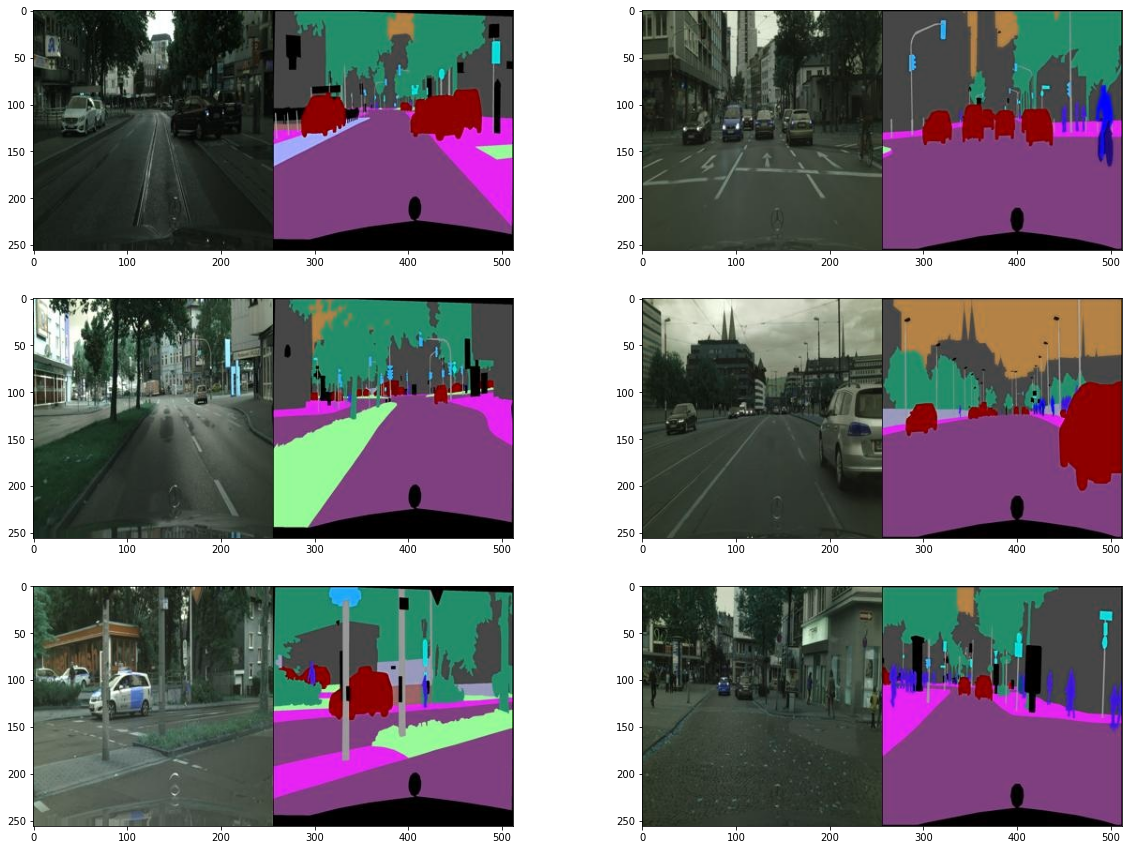

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지 데이터 눈으로 확인. 랜덤 6개 이미지 
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(500)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
# 이미지 사이즈 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


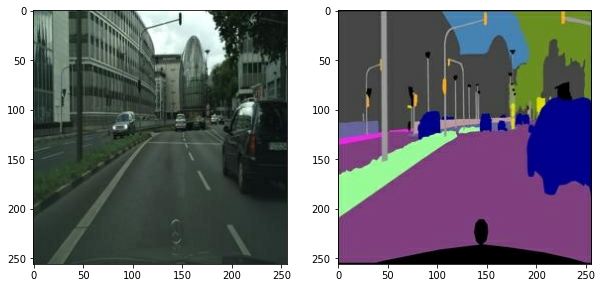

In [5]:
# (256,256,3) 크기의 2개 이미지로 분할
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [6]:
# data augmentation 함수 
# (데이터셋을 여러가지 방법으로 확대하여 실질적인 학습 데이터 셋의 규모를 키울 수 있는 방법)

from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1) # 두 이미지가 채널 축으로 연결됩니다. 
    
    # padding
    _pad = tf.constant([[30,30],[30,30],[0,0]]) # pad width
    if tf.random.uniform(()) < .5: # 50% 확률
        padded = tf.pad(stacked, _pad, "REFLECT") # Refection padding
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.) # Constant padding

    out = image.random_crop(padded, size=[256, 256, 6]) # (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다.
    
    out = image.random_flip_left_right(out) # 50% 확률로 가로로 뒤집습니다.
    out = image.random_flip_up_down(out) # 50% 확률로 세로로 뒤집습니다.
    
    if tf.random.uniform(()) < .5: # 50% 확률
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree) # 회전
    
    return out[...,:3], out[...,3:]   

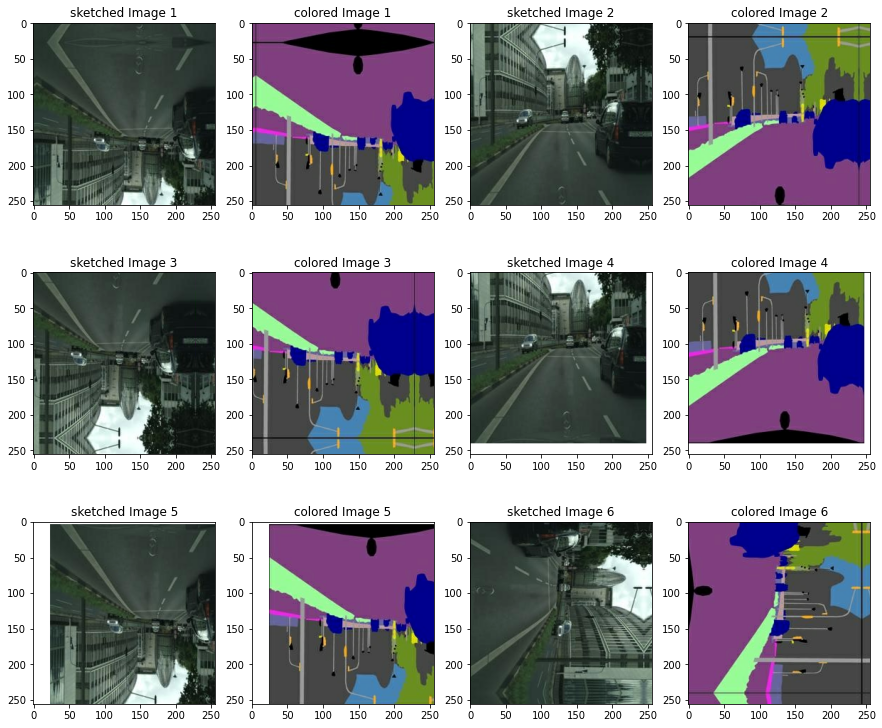

In [7]:
# data augmentation 적용
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"sketched Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"colored Image {img_n}")
    img_n += 1

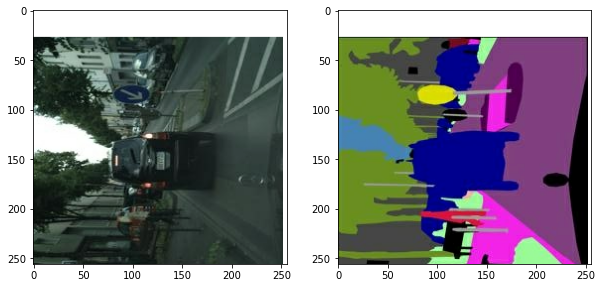

In [8]:
from tensorflow import data

# 샘플이미지 확인
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 2. Generator 구성하기 (U-Net)
U-Net 아키텍쳐
![unet](https://d3s0tskafalll9.cloudfront.net/media/images/p2p_generator_unet.max-800x600.png)
각 레이어마다 Encoder와 Decoder가 연결(skip connection)되어 있다

In [9]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [10]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x) # skip connection: encoder 내에서 사용된 각 Block들의 출력을 리스트로 저장 (U-net의 특징)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat]) # Decoder의 입력에 에 Encoder의 최종출력으로 들어간다
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [11]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## 3. Discriminator 구성하기

In [12]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [13]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        filters = [64,128,256,512,1] # filter sizes
        self.blocks = [layers.Concatenate()]
        
        # for문을 통한 blcok 쌓기
        for i, f in enumerate(filters):
            self.blocks.append(
                DiscBlock(
                    n_filters=f,
                    stride=2 if i < 3 else 1,
                    custom_pad=False if i < 3 else True,
                    use_bn=False if i==0 and i==4 else True,
                    act=True if i < 4 else False
            ))
        self.sigmoid = layers.Activation(activation='sigmoid') # 마지막은 sigmoid
        
    
    def call(self, x, y):
        out = self.blocks[0]([x, y])
        out = self.blocks[1](out)
        out = self.blocks[2](out)
        out = self.blocks[3](out)
        out = self.blocks[4](out)
        out = self.blocks[5](out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [14]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6400        concatenate_7[0][0]        

## 4. 학습 및 테스트하기

In [16]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False) # Cross Entropy
mae = losses.MeanAbsoluteError() # MAE(Mean Absolute Error)

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output) 
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [17]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [31]:
@tf.function # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 

# 하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) # L1 손실 반영 lambda=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)

    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [32]:
EPOCHS = 15

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]}

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)      
            
            
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 200 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[200]                     
Generator_loss:0.7146                     
L1_loss:0.2464                     
Discriminator_loss:1.4824

EPOCH[2] - STEP[200]                     
Generator_loss:0.7070                     
L1_loss:0.2306                     
Discriminator_loss:1.4739

EPOCH[3] - STEP[200]                     
Generator_loss:0.6973                     
L1_loss:0.1895                     
Discriminator_loss:1.4535

EPOCH[4] - STEP[200]                     
Generator_loss:0.7103                     
L1_loss:0.2082                     
Discriminator_loss:1.4674

EPOCH[5] - STEP[200]                     
Generator_loss:0.6908                     
L1_loss:0.1634                     
Discriminator_loss:1.4149

EPOCH[6] - STEP[200]                     
Generator_loss:0.6933                     
L1_loss:0.1226                     
Discriminator_loss:1.4066

EPOCH[7] - STEP[200]                     
Generator_loss:0.6915                     
L1_loss:0.1530             

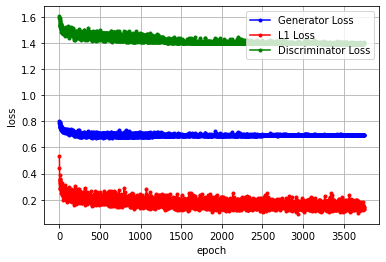

In [33]:
# epoch에 따른 loss 시각화
x_len = np.arange(len(history['l1_loss']))
plt.plot(x_len, history['gen_loss'], marker='.', c='blue', label="Generator Loss")
plt.plot(x_len, history['l1_loss'], marker='.', c='red', label="L1 Loss")
plt.plot(x_len, history['disc_loss'], marker='.', c='green', label="Discriminator Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [34]:
val_path = os.getenv('HOME')+'/aiffel/workplace/exploration/ex07/cityscapes/val/'
print("number of train examples :", len(os.listdir(val_path)))

number of train examples : 5


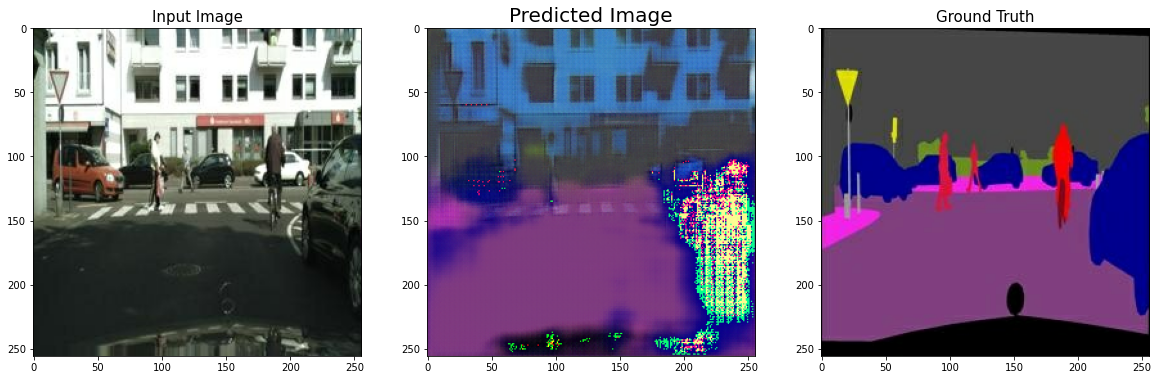

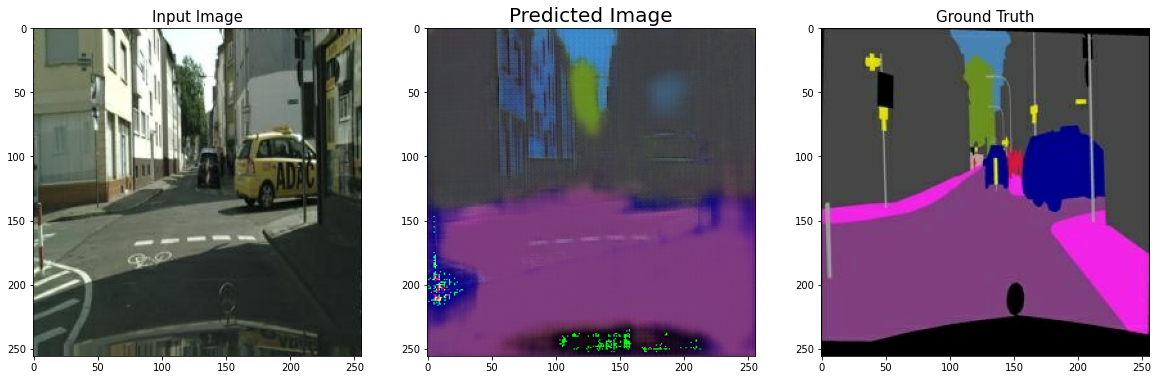

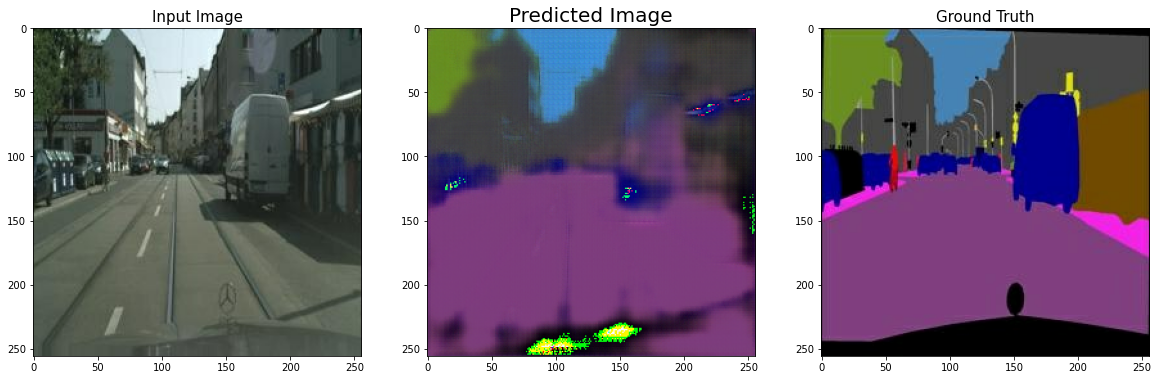

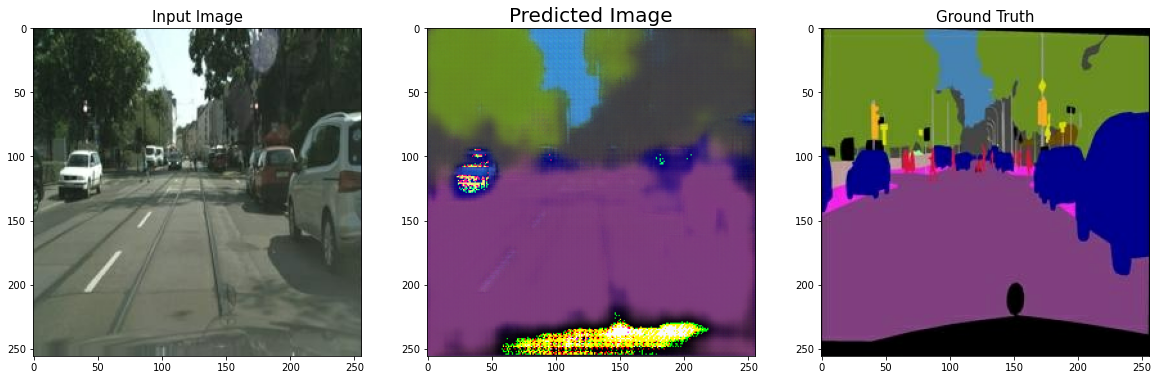

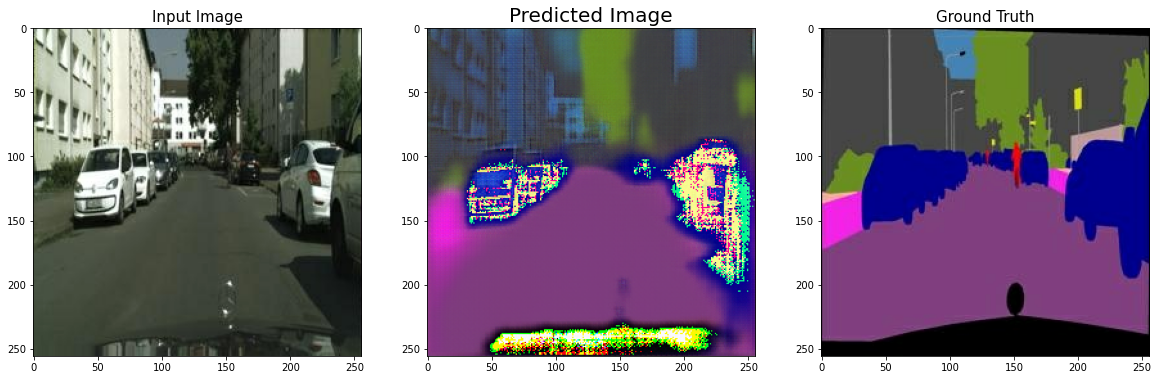

In [35]:
for i in range(5):
    f = val_path + os.listdir(val_path)[i]
    input_image, real_image = load_img(f)

    pred = generator(tf.expand_dims(input_image, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(input_image)); plt.title('Input Image', fontsize=15)
    plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image', fontsize=20)
    plt.subplot(1,3,3); plt.imshow(denormalize(real_image)); plt.title('Ground Truth', fontsize=15)

# 회고
ResNet에서 사용한 skip connection이 U-net에서도 쓰이는 걸 알았다. 생성모델에서도 쓰인다는 점이 신선했다. 그리고 단일 픽셀이 아닌 주변 픽셀까지 포함한 Patch를 계산해서 생성을 고려한다는 점을 배웠다. 코드 상에서는 epoch를 늘릴 수록 생성이미지의 품질이 그럴듯하게 바뀌는 과정이 신기했다.